# Boundary Value Solver

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_bvp
from scipy.optimize import root
from scipy.spatial.distance import euclidean

plt.rcParams['figure.figsize'] = (10,5)
np.set_printoptions(precision=2)

\begin{matrix} v'=v^2-\frac{11}{10}v+\frac 53e \\ e'=-\frac 12v^3+\frac{11}{10}v^2-\frac{33}{50}v+ve\text. \end{matrix}

Jacobian is $\begin{bmatrix} 2v-1.1 & \frac{5}{3} \\ -1.5v^2 + 2.2v - 0.66 + e & v\end{bmatrix}$.  
At (0,0), the Jacobian is $\begin{bmatrix} -1.1 & \frac{5}{3} \\ -0.66 & 0\end{bmatrix}$. Eigenvectors are $(0.83 \pm 1.35i, 1)$.  
At (1, 0.06), the Jacobian is $\begin{bmatrix} 0.9 & \frac{5}{3} \\ 0.1 & 1 \end{bmatrix}$. Eigenvectors are $(3.61, 1)$ and $(-4.61, 1)$. 

![title](viz_mono.png)

## Problem 1
Determine the fixed points of the ODE system and classify their type.
To classify their type, state that the fixed point is a center, saddle, sink, etc.

$(v,e)$  
$(0,0)$ - spiral sink  
$(0.6, 0.18)$ - saddle  
$(1, 0.06)$ - source  

## Problem 2
Draw a phase portrait for the ODE system. Include fixed points, connecting orbits, and a few representative orbits.

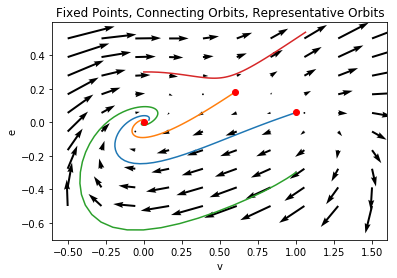

[0.9999999999999992] [0.06000000000000014]


In [11]:
dv = lambda v, e: v**2 - 1.1*v + 5/3*e
de = lambda v, e: -0.5*v**3 + 1.1*v**2 - 0.66*v + v*e

α = 0.1

def solve_forward(v0, e0, n_forward=100):
    vs, es = [v0], [e0]
    v, e = v0, e0
    for i in range(n_forward):
        delta_v = dv(v, e)
        delta_e = de(v, e)
        v += α*delta_v
        e += α*delta_e
        vs.append(v)
        es.append(e)
    return vs, es

def solve_backward(vn, en, n_backward=100):
    vs, es = [vn], [en]
    v, e = vn, en
    for i in range(n_backward):
        delta_v = dv(v, e)
        delta_e = de(v, e)
        v -= α*delta_v
        e -= α*delta_e
        vs.append(v)
        es.append(e)
    return vs, es

n_density = 10

fixed_points = np.array([
    [0, 0],
    [0.6, 0.18],
    [1, 0.06]
])

V = np.linspace(-0.5, 1.5, n_density)
E = np.linspace(-0.5, 0.5, n_density)
X, Y = np.meshgrid(V, E)

vs_1, es_1 = solve_forward(1, 0.059)
vs_2, es_2 = solve_forward(0.6, 0.179)
vs_3, es_3 = solve_forward(1, -0.3)
vs_4, es_4 = solve_forward(0, 0.3, n_forward=40)
vs_5, es_5 = solve_backward(0.61, 0.18, n_backward=1000)

plt.quiver(X, Y, dv(X,Y), de(X,Y))
plt.plot(vs_1, es_1)
plt.plot(vs_2, es_2)
plt.plot(vs_3, es_3)
plt.plot(vs_4, es_4)
# plt.plot(vs_5, es_5, color='purple', linewidth=3)
plt.scatter(fixed_points[:,0], fixed_points[:,1], color='red', zorder=3)
plt.xlabel("v")
plt.ylabel("e")
plt.title("Fixed Points, Connecting Orbits, Representative Orbits")
plt.show()

print(vs_5[-1:], es_5[-1:])

## Problem 3 & 4
Develop from scratch an ODE boundary solver.
Use your ODE boundary solver to solve for any connecting orbits present in the phase diagram.

Why does gradient explosion depend on the time linspace?
Because $dv, de$ are actually $\frac{dv}{dt}, \frac{de}{dt}$.

Supposedly, we can just specify one starting point and it will end up at the correct endpoint.
Start in the direction of the eigenvalue?

Sol: <scipy.interpolate.interpolate.PPoly object at 0x000002092AC6EEB8>


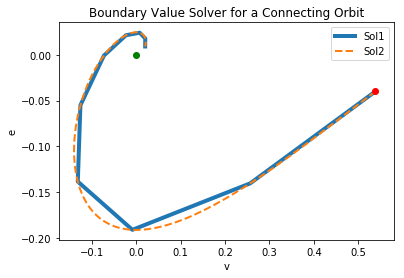

In [3]:
# Define ODE
def fun(t, y):
    v, e = y
    delta_v = dv(v, e)
    delta_e = de(v, e)
    ret_val = np.vstack([delta_v, delta_e])
    return ret_val

eig_alpha = 0.1
eigv, eige = -4.61, 1
v0, e0 = 1 + eig_alpha*eigv, 0.06 - eig_alpha*eige
vn, en = 0, 0.01
# Define boundary condition residual
def bcs(ya, yb):
    return np.array([ya[0]-v0, ya[1]-e0])

# Init time and boundary conditions
t1 = np.linspace(0, 6, 10)
t2 = np.linspace(0, 6, 800)
bc = np.array([v0, e0])
y = bc.reshape((-1,1)) * np.ones((2,len(t1)))

# Solve the ODE
sol = solve_bvp(fun=fun, bc=bcs, x=t1, y=y).sol
print("Sol:", sol)
sol1 = solve_bvp(fun=fun, bc=bcs, x=t1, y=y).sol(t1)
sol2 = solve_bvp(fun=fun, bc=bcs, x=t1, y=y).sol(t2)

# Plot it all
plt.plot(sol1[0], sol1[1], linewidth=4, label="Sol1")
plt.plot(sol2[0], sol2[1], '--', linewidth=2, label="Sol2")
plt.scatter(sol1[0][0], sol1[1][0], color='red', zorder=3)
plt.scatter([0], [0], color='green')
plt.xlabel("v")
plt.ylabel("e")
plt.title("Boundary Value Solver for a Connecting Orbit")
plt.legend()
plt.show()

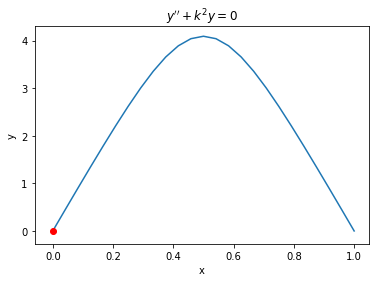

In [4]:
k = 1
def fun(x, y):
    """
    Params:
    x (m,) ndarray: the number of points to be 
    y (n,m) ndarray
    Returns:
    y' (n,m) ndarray
    """
    assert y.shape[1] == x.shape[0], "Invalid y shape, {}".format(y.shape)
    return np.vstack((y[1], -np.exp(y[0])))

def bc(ya, yb):
    return np.array([ya[0], yb[0]])

x = np.linspace(0, 1, 25)
y = np.zeros((2, x.size)) # first row is y, second row is y'
y[0] = 3
y[1] = 3
# print(y)

sol = solve_bvp(fun, bc, x, y).sol(x)
# print(sol)

plt.plot(x, sol[0])
# plt.plot(x, sol[1])
plt.scatter(x[0], sol[0][0], color='red', zorder=3)
plt.xlabel("x")
plt.ylabel("y")
plt.title(r"$y'' + k^2y = 0$")
plt.show()

x: [0.   0.04 0.08 0.12 0.17 0.21 0.25 0.29 0.33 0.38 0.42 0.46 0.5  0.54
 0.58 0.62 0.67 0.71 0.75 0.79 0.83 0.88 0.92 0.96 1.  ]
y': [[  3.     3.     3.     3.     3.     3.     3.     3.     3.     3.
    3.     3.     3.     3.     3.     3.     3.     3.     3.     3.
    3.     3.     3.     3.     3.  ]
 [-20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09
  -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09 -20.09
  -20.09 -20.09 -20.09 -20.09 -20.09]]
[0.   0.13 0.25 0.38 0.5  0.63 0.75 0.88 1.   1.13 1.25 1.38 1.5  1.63
 1.75 1.88 2.   2.13 2.25 2.38 2.5  2.63 2.75 2.88 3.  ]
-0.0

x: [0.   0.04 0.08 0.12 0.17 0.21 0.25 0.29 0.33 0.38 0.42 0.46 0.5  0.54
 0.58 0.62 0.67 0.71 0.75 0.79 0.83 0.88 0.92 0.96 1.  ]
y': [[  3.     3.     3.     3.     3.     3.     3.     3.     3.     3.
    3.     3.     3.     3.     3.     3.     3.     3.     3.     3.
    3.     3.     3.     3.     3.  ]
 [ -1.    -1.13  -1.28  -1.45  -1.65  -1.87  -2.12  -2.4 

C:\Users\T440\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned
C:\Users\T440\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: RankWarning: Polyfit may be poorly conditioned


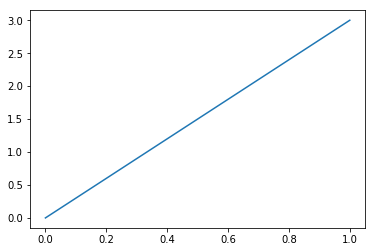

In [5]:
def my_solve_bvp(fun, bc, x, y):
    """
    Need to involve the boundary conditions, otherwise it goes to 0.
    This works for boundary conditions at ya/yb, not for the derivatives.
    Params:
    x ((m,) ndarray): the points to interpolate the derivative at.
    y ((n,m) ndarray): the solution estimate at the mesh nodes.
    Returns:
    y ((n,m) ndarray): the new solution estimate at the mesh nodes.
    """
    # We'll gather the derivatives at a linspace of points.
    y_prime = fun(x, y) # [y', y'']
    print("x:", x)
    print("y':", y_prime)
    # We'll interpolate the points with a polynomial.
    deg = len(x)-1
    dy_p = np.polyfit(x, y_prime[0], deg=deg)
    dy_hat = np.polyval(dy_p, x)
    # We'll interpolate the polynomial.
    y_p = np.polyint(dy_p, k=0)
    # Now add the integration constant
    y_hat_without_k = np.polyval(y_p, x)
    k = -bc(y_hat_without_k, y_hat_without_k)[0]
    print(y_hat_without_k)
    print(k)
    print("")
    y_p[-1] += k
    y_hat = np.polyval(y_p, x)
    return np.vstack((y_hat, dy_hat))

y_hat = y
for i in range(2):
    y_hat = my_solve_bvp(fun, bc, x, y_hat)

plt.plot(x, y_hat[0])
plt.show()

In [10]:
# This module contains the boundary value solver code, which we call in the Jupyter Notebook.
import numpy as np
from scipy.optimize import root
from matplotlib import pyplot as plt

def fsolve_input(cf, a, b, dim, deg, ode, bc):
    """
    Returns the list of functions we want to equal 0. [f(x), g(x), ...]
    Parameters:
        cf ((n+1,dim) ndarray): Chebyshev coefficients.
        a (int): the starting point
        b (int): the ending point
        dim (int): the dimension of the system.
        deg (int): the degree of the polynomial.
        ode (function): the system we're trying to solve. y'(y,t) = f(y,t).
        bc (function): the boundary conditions which should equal zero.
    Returns:
        (list(function)): the system of equations to set to zero.
    """
    cf = cf.reshape((dim,deg+1))
    cf = np.array(cf)
    
    # Chebyshev extrema nodes
    x = np.array(list(reversed(np.cos((np.pi * np.arange(deg + 1)) / deg))))
    # scale to (a, b)
    x = (x * (b - a) + b + a) / 2
    print(x)
    
    # polynomial evaluated at nodes
    cheb_poly = [np.polynomial.chebyshev.Chebyshev(coeffs, (a, b)) for coeffs in cf]
    
    p = np.array([cheb_poly[i](x) for i in range(dim)])

    # polynomial at the end points
    ya = p[:, 0]
    yb = p[:, -1]

    # coefficients of the derivative of the polynomial
    cheb_poly_der = [cheb_poly[i].deriv() for i in range(dim)]

    # derivative of polynomial evaluated at the nodes
    p_der = np.array([cheb_poly_der[i](x) for i in range(dim)])

    # output for fsolve
    functions_that_equal_zero = [
        *np.ravel(bc(ya, yb)),  # boundary conditions
        *np.ravel((p_der - ode(x,p)))  # ODE conditions
    ]
    return functions_that_equal_zero

# n = 5
# dim = 2
# cf = np.zeros((n,dim))
# fsolve_input(
#     cf=
# )


In [ ]:
def cheb_bvp_solve(fun, bc, x, y, tol=1e-3 #ode, a, b, n, u0, dim, bc, tol=1e-10):
    """
    Solves a boundary value problem using Chebyshev collocation. Returns a list of functions that form the solution to
    the problem.
    Parameters:
        fun
        u0 ((deg+1,n) ndarray): the initial guess for y.
    """

    y0 = np.polynomial.chebyshev.chebfit(np.linspace(a, b, len(u0)), u0, 20)
    plt.plot()

    solution = root(lambda u: fun(u, a, b, dim, n, f, bc), y0, method='lm', tol=tol)
    assert solution.success, "Root finding failed."

    cf = solution.x
    cf = cf.reshape((dim, cf.size // dim))

    return [np.polynomial.chebyshev.Chebyshev(cf[i], (a, b)) for i in range(dim)]

def run_cheb_solve():

    f = lambda x, y: np.array([
        y[1],
        -np.exp(y[0])
    ])

    a = 0
    b = 1
    n = 20
    dim = 2

    def bc(ya, yb):
        return np.array([ya[0], yb[0]])

    u0 = np.zeros((n + 1, dim))
    u0[0, 0] = 3
    u0[:, 1] = np.exp(u0[:, 0])

    x = np.linspace(a, b, n)
    solution = cheb_bvp_solve(f, bc, x, u0, dim)

    # plotting
    dom = np.linspace(a, b, 1000)
    plt.plot(dom, solution[0](dom),
            #  np.polynomial.chebyshev.Chebyshev(cf[1], (a, b))(dom),
             label='estimate')
    plt.legend()
    plt.show()
    
run_cheb_solve()

Sol: <scipy.interpolate.interpolate.PPoly object at 0x000002092AE56C50>


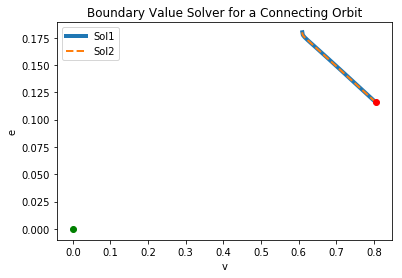

In [7]:
# Define ODE
def fun(t, y):
    v, e = y
    delta_v = dv(v, e)
    delta_e = de(v, e)
    ret_val = np.vstack([delta_v, delta_e])
    return ret_val

eig_alpha = 0.1
eigv, eige = -4.61, 1
v0, e0 = 1 + eig_alpha*eigv, 0.06 - eig_alpha*eige
vn, en = 0, 0.01
# Define boundary condition residual
def bcs(ya, yb):
    return np.array([yb[0]-0.61, yb[1]-0.18])

# Init time and boundary conditions
t1 = np.linspace(0, 10, 10)
t2 = np.linspace(0, 10, 800)
bc = np.array([v0, e0])
y = bc.reshape((-1,1)) * np.ones((2,len(t1)))

# Solve the ODE
sol = solve_bvp(fun=fun, bc=bcs, x=t1, y=y).sol
print("Sol:", sol)
sol1 = solve_bvp(fun=fun, bc=bcs, x=t1, y=y).sol(t1)
sol2 = solve_bvp(fun=fun, bc=bcs, x=t1, y=y).sol(t2)

# Plot it all
plt.plot(sol1[0], sol1[1], linewidth=4, label="Sol1")
plt.plot(sol2[0], sol2[1], '--', linewidth=2, label="Sol2")
plt.scatter(sol1[0][0], sol1[1][0], color='red', zorder=3)
plt.scatter([0], [0], color='green')
plt.xlabel("v")
plt.ylabel("e")
plt.title("Boundary Value Solver for a Connecting Orbit")
plt.legend()
plt.show()